<a href="https://colab.research.google.com/github/bccp/DeepUQ/blob/master/ImageCorruptionMNIST_blurred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Example 3: blurred image of a 9

---



In [0]:
import os
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [0]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     \ 10.8MB 1.2MB/s


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [0]:

PROJECT_PATH = os.path.abspath('../')
print(PROJECT_PATH)

# pathes to trained generative models
generator_path   = os.path.join(PROJECT_PATH,'modules/decoder1/decoder')
encoder_path     = os.path.join(PROJECT_PATH,'modules/encoder1/encoder')
nvp_func_path    = os.path.join(PROJECT_PATH,'modules/nvp1/')
minima_path      = os.path.join(PROJECT_PATH,'minima/')
plot_path        = os.path.join(PROJECT_PATH,'plots/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/BDL2019
/content/gdrive/My Drive/BDL2019/modules/GaussianVAEs/July312019/decoder/
True
True


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
data_dim    = 28*28
data_size   = 1
sigma_n     = 0.1254
hidden_size = 8
n_channels  = 1
seed        = 777


# settings for reconstruction with uncorrupted data
# corr_type   = 'none'
# num_mnist   = 6
# label       = 'uncorrupted'
# noise_level = 0.0
# num_comp    = 2

# settings for reconstrcution with rectangular mask
corr_type   = 'conv'
num_mnist   = 12
label       = 'GaussConv'
noise_level = 0.0
num_comp    = 3
G_mean      = 0.
G_std       = 3.

#settings for reconstruction with sparse mask 
# corr_type   = 'sparse mask'
# num_mnist   = 1
# label       = 'sparse95'
# noise_level = 0.
# num_comp    = 2

# settings for reconstruction with noise
# corr_type   = 'noise'
# num_mnist   = 6
# label       = 'noise05'
# noise_level = 0.5
# num_comp    = 4

# settings for reconstruction with noise and mask
# corr_type   = 'noise+mask'
# num_mnist   = 6
# label       = 'masknoise05'
# noise_level = 0.5
# num_comp    = 2

In [0]:
minima_path      = os.path.join(PROJECT_PATH, 'minima/%s/'%label)
plot_path        = os.path.join(PROJECT_PATH, 'plots/%s/'%label)

if not os.path.isdir(plot_path):
  os.makedirs(plot_path)
  
if not os.path.isdir(minima_path):
  os.makedirs(minima_path)

In [0]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  
  if np.any(mask==None):
    mask=np.ones_like(image)
  mask = np.reshape(mask,(28,28))
  plt.figure()
  #plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  #plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  
  sigma = np.ones(shape)*sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
      
  data_noise = np.ones_like(sigma)*noise_level
  
  sigma = np.sqrt(sigma**2+data_noise**2)
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 10
    maxx = 24
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true*[mask]
    
  elif corr_type=='sparse mask':
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print('precentage masked:', len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*[mask]
    
  elif corr_type=='noise':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    corr_data = x_true+noise
    
  elif corr_type=='noise+mask':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    minx = 14
    maxx = 28
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true+noise
    corr_data = corr_data*[mask]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  elif corr_type=='conv':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  mask = mask.flatten()
  
  return corr_data, mask

In [0]:
def gaussian_kernel(size: int, mean: float, std: float):

    G = tfd.Normal(mean, std)

    vals = G.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',vals,vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

In [0]:
def fwd_pass(generator,nvp,z,mask):
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']

  gen_z           = tf.boolean_mask(tf.reshape(generator(fwd_z),[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask,gauss_kernel):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  gen_z           = tf.reshape(gen_z,[data_size, 28,28,1])

  # Convolve.
  conv_gen        = tf.reshape(tf.nn.conv2d(gen_z, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME"),[data_size,data_dim,n_channels])
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=conv_gen,scale_diag=sigma))

  return likelihood


def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta, gauss_kernel):

  likelihood      = get_likelihood(generator,nvp,z,sigma,mask, gauss_kernel)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask,gauss_kernel):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  recon           = tf.reshape(gen_z,[data_size, 28,28,1])
  
  return recon

def get_hessian(func, z):
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):


  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [0]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3],[10000,5000,3000]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
        
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.plot(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def
  

In [0]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
  
  samples=[]
  for ii in range(num):
    samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [0]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  plt.figure(figsize(5,5))
  #plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.savefig(plot_path+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plt.figure(figsize(5,5))
    plt.title('masked'+title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')     
    plt.savefig(plot_path+filename+'masked.pdf',bbox_inches='tight')
    plt.show()

In [0]:
def get_random_start_values(num, my_sess):
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [0]:
def get_chi2(sigma,data,mean,masking=False, mask=None,threshold=0.02):
  
  if masking:
    mask = np.reshape(mask,data.shape)
    mean = np.reshape(mean,data.shape)[np.where(mask==1)]
    sigma= np.reshape(sigma, data.shape)[np.where(mask==1)]
    data = data[np.where(mask==1)]
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  
  if corr_type not in ['noise','noise+mask']:
    chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
    dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
    chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
    dof_high = len(np.squeeze(data[np.where(data>threshold)]))
  else:
    chi2_low = None
    dof_low  = None
    chi2_high= None
    dof_high = None
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [0]:
def plot_minima(minima, losses, var):

  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.png'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.png'%(label),bbox_inches='tight')
  plt.show()

In [0]:
def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):

  _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
  _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    H    = exact_hessian[0,nn,nn]
    HGN  = approx_hessian[0,nn,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    title('latent space direction %d'%nn)
    
    Delta   = 0.1
    steps   = 1000
    delta_z = np.zeros((steps,hidden_size))

    delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
    new_ini       = delta_z+minimum

    for ii in range(steps):
      _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(new_ini[ii],axis=0), sigma_corr:noise})
      ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
      losses.append(ll)
     

    

    plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='estimate from exact Hessian')
    #plt.plot(new_ini[:,nn],ll0+HGN*delta_z[:,nn]**2,label='estimate from Gauss-Newton')
    plt.plot(new_ini[:,nn],losses,label='probed posterior', lw=2)
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(min(losses),min(losses)+1.5)

  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_%s.png'%(filename),bbox_inches='tight')
  plt.show()


In [0]:
def get_gmm_parameters(minima, x, noise, mymask, offset):
  mu   =[]
  w    =[]
  sigma=[]
  print(len(minima), num_comp)
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    mu+=[minima[ii]]
    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

    # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
    logdet  = sess.run(tf.linalg.logdet(approx_posterior_laplace.covariance()),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    w+=[np.exp(0.5*logdet+logprob+offset)]
    
  print('weights of Gaussian mixtures:', w/np.sum(w))
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma),[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w))
                         
  return mu, sigma, w
                                 

In [0]:
def plot_prob_2D_GMM(samples, indices):

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.pdf'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

In [0]:
tf.reset_default_graph()

input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)
sigma_corr  = tf.placeholder_with_default(np.ones([data_size,data_dim,n_channels], dtype='float32')*sigma_n,shape=[data_size,data_dim,n_channels])
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])


in_data  = tf.reshape(input_data, [data_size, 28,28,1])

gauss_kernel= gaussian_kernel(5,G_mean,G_std)

gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]

# Convolve.
conv_gen     = tf.nn.conv2d(in_data, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")

in_data      = tf.reshape(conv_gen,[data_size,data_dim,n_channels])

inverse_T   = tf.placeholder_with_default(1., shape=[])
lr          = tf.placeholder_with_default(0.001,shape=[])

generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_func_path, trainable=False)

MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))


nlPost_MAP  = get_log_posterior(MAP, in_data, generator,nvp_funcs, sigma_corr,mask, inverse_T, gauss_kernel)
loss_MAP    = -tf.reduce_mean(nlPost_MAP)

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)

opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask,gauss_kernel)

hessian     = get_hessian(-nlPost_MAP,MAP)

GN_hessian  = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)

ini_val  = np.ones((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((data_size,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float32)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update_mu          = mu_new.assign(MAP)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
update_TriL        = sigma_new_t2.assign(tf.linalg.cholesky(covariance))

posterior_sample   = approx_posterior_laplace.sample()

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask, gauss_kernel)

ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask,gauss_kernel)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


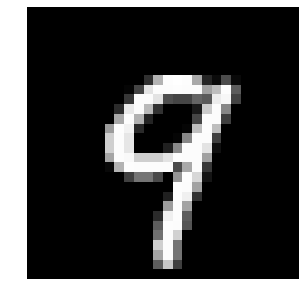

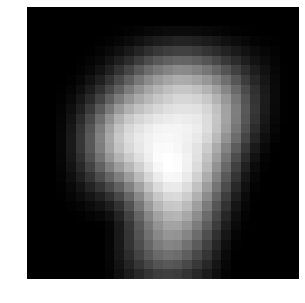

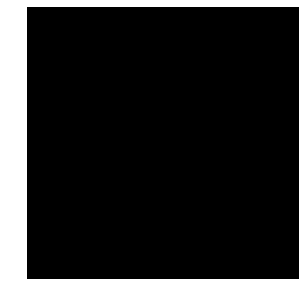

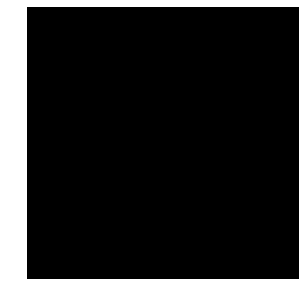

progress in % 0.0
lrate 0.1
iter 0 loss -87.65376 inverse T 0.2
iter 1000 loss -162.66716 inverse T 0.2
iter 2000 loss -165.32141 inverse T 0.2
iter 3000 loss -167.87999 inverse T 0.2
iter 4000 loss -257.00388 inverse T 0.3
iter 5000 loss -256.94547 inverse T 0.3
iter 6000 loss -256.98203 inverse T 0.3
iter 7000 loss -346.04636 inverse T 0.4
iter 8000 loss -346.03177 inverse T 0.4
iter 9000 loss -434.85245 inverse T 0.5
lrate 0.01
iter 0 loss -880.00226 inverse T 1.0
iter 1000 loss -880.5593 inverse T 1.0
iter 2000 loss -880.5523 inverse T 1.0
iter 3000 loss -880.56085 inverse T 1.0
iter 4000 loss -880.56226 inverse T 1.0
lrate 0.001
iter 0 loss -880.5628 inverse T 1.0
iter 1000 loss -880.56354 inverse T 1.0
iter 2000 loss -880.5637 inverse T 1.0


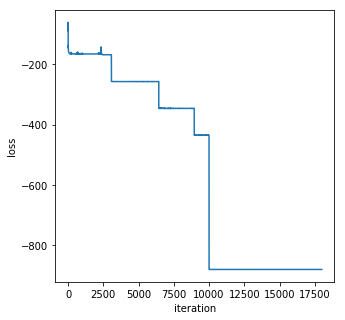

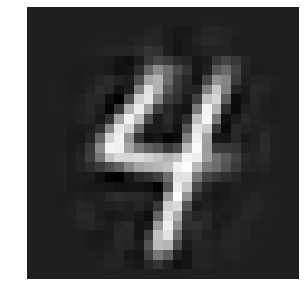

[[ 1.1157259e-01  4.2772722e-01  5.9060252e-01  1.1144372e-01
   1.7776358e-03  1.7346406e-01  2.3673756e+00 -1.9143902e-01]]
hessian postive definite
progress in % 10.0
lrate 0.1
iter 0 loss -148.24287 inverse T 0.2
iter 1000 loss -168.20584 inverse T 0.2
iter 2000 loss -168.20557 inverse T 0.2
iter 3000 loss -168.19101 inverse T 0.2
iter 4000 loss -256.83963 inverse T 0.3
iter 5000 loss -256.2158 inverse T 0.3
iter 6000 loss -257.43033 inverse T 0.3
iter 7000 loss -344.35013 inverse T 0.4
iter 8000 loss -345.56503 inverse T 0.4
iter 9000 loss -434.40884 inverse T 0.5
lrate 0.01
iter 0 loss -880.8347 inverse T 1.0
iter 1000 loss -881.04974 inverse T 1.0
iter 2000 loss -881.0499 inverse T 1.0
iter 3000 loss -881.04913 inverse T 1.0
iter 4000 loss -881.05 inverse T 1.0
lrate 0.001
iter 0 loss -881.0493 inverse T 1.0
iter 1000 loss -881.0519 inverse T 1.0
iter 2000 loss -881.0517 inverse T 1.0


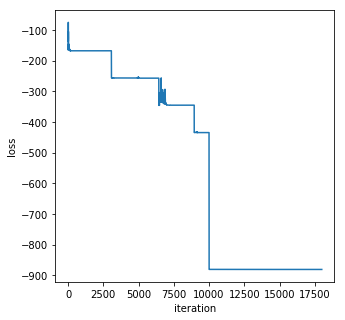

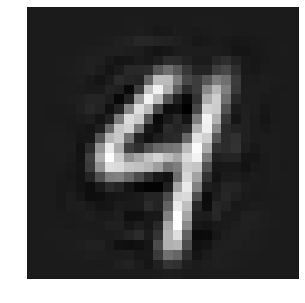

[[ 0.15633428  1.0578312   1.294907   -0.16535473 -0.56821465 -0.60869896
   2.1273851  -0.0062313 ]]
hessian postive definite
progress in % 20.0
lrate 0.1
iter 0 loss -156.1062 inverse T 0.2
iter 1000 loss -166.97682 inverse T 0.2
iter 2000 loss -168.07408 inverse T 0.2
iter 3000 loss -168.17761 inverse T 0.2
iter 4000 loss -260.8601 inverse T 0.3
iter 5000 loss -260.84967 inverse T 0.3
iter 6000 loss -260.85873 inverse T 0.3
iter 7000 loss -349.65326 inverse T 0.4
iter 8000 loss -349.65082 inverse T 0.4
iter 9000 loss -439.29022 inverse T 0.5
lrate 0.01
iter 0 loss -878.1026 inverse T 1.0
iter 1000 loss -887.62445 inverse T 1.0
iter 2000 loss -887.62506 inverse T 1.0
iter 3000 loss -887.62 inverse T 1.0
iter 4000 loss -887.6242 inverse T 1.0
lrate 0.001
iter 0 loss -887.6239 inverse T 1.0
iter 1000 loss -887.62616 inverse T 1.0
iter 2000 loss -887.6262 inverse T 1.0


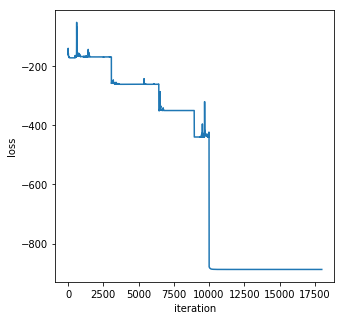

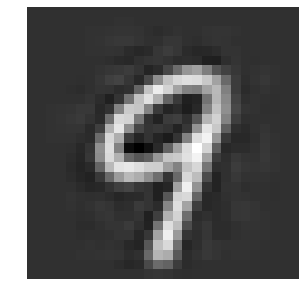

[[ 0.37451562  0.5318776   0.70817935 -0.25479996 -0.37646315 -0.877638
   0.29591265 -0.05069678]]
hessian postive definite
progress in % 30.0
lrate 0.1
iter 0 loss -140.55978 inverse T 0.2
iter 1000 loss -146.73047 inverse T 0.2
iter 2000 loss -146.9846 inverse T 0.2
iter 3000 loss -145.82013 inverse T 0.2
iter 4000 loss -257.45135 inverse T 0.3
iter 5000 loss -257.44952 inverse T 0.3
iter 6000 loss -257.444 inverse T 0.3
iter 7000 loss -346.27744 inverse T 0.4
iter 8000 loss -346.25974 inverse T 0.4
iter 9000 loss 47.559635 inverse T 0.5
lrate 0.01
iter 0 loss -856.03796 inverse T 1.0
iter 1000 loss -856.5337 inverse T 1.0
iter 2000 loss -856.5338 inverse T 1.0
iter 3000 loss -856.5335 inverse T 1.0
iter 4000 loss -856.53 inverse T 1.0
lrate 0.001
iter 0 loss -856.5312 inverse T 1.0
iter 1000 loss -856.5365 inverse T 1.0
iter 2000 loss -856.5358 inverse T 1.0


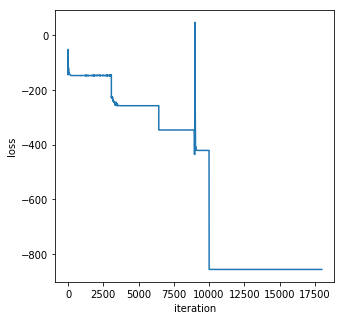

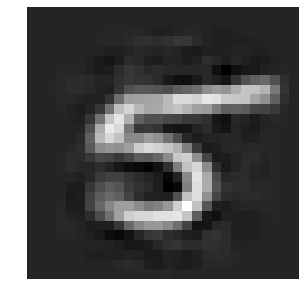

[[-1.6657491  -0.54863197  2.7481973   0.65702903 -0.5068616   0.24464339
   0.8157182   1.9558156 ]]
hessian postive definite
progress in % 40.0
lrate 0.1
iter 0 loss -130.92873 inverse T 0.2
iter 1000 loss -161.38815 inverse T 0.2
iter 2000 loss -162.28769 inverse T 0.2
iter 3000 loss -168.47064 inverse T 0.2
iter 4000 loss -257.35312 inverse T 0.3
iter 5000 loss -257.3486 inverse T 0.3
iter 6000 loss -257.32144 inverse T 0.3
iter 7000 loss -346.0526 inverse T 0.4
iter 8000 loss -345.97302 inverse T 0.4
iter 9000 loss -434.95383 inverse T 0.5
lrate 0.01
iter 0 loss -880.15137 inverse T 1.0
iter 1000 loss -880.562 inverse T 1.0
iter 2000 loss -880.5572 inverse T 1.0
iter 3000 loss -880.55414 inverse T 1.0
iter 4000 loss -880.56256 inverse T 1.0
lrate 0.001
iter 0 loss -880.5627 inverse T 1.0
iter 1000 loss -880.5665 inverse T 1.0
iter 2000 loss -880.56647 inverse T 1.0


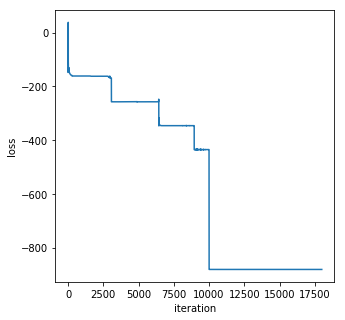

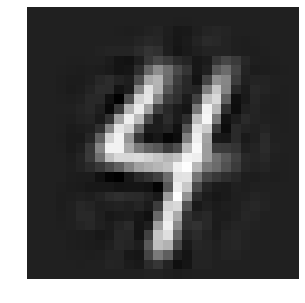

[[ 0.11199628  0.3403857   0.60538644  0.11059016  0.01798576  0.16891406
   2.3500998  -0.19322272]]
hessian postive definite
progress in % 50.0
lrate 0.1
iter 0 loss -158.99287 inverse T 0.2
iter 1000 loss -163.82843 inverse T 0.2
iter 2000 loss -164.17401 inverse T 0.2
iter 3000 loss -164.19215 inverse T 0.2
iter 4000 loss -251.8541 inverse T 0.3
iter 5000 loss -252.63808 inverse T 0.3
iter 6000 loss -252.66333 inverse T 0.3
iter 7000 loss -340.34116 inverse T 0.4
iter 8000 loss -340.4147 inverse T 0.4
iter 9000 loss -428.30655 inverse T 0.5
lrate 0.01
iter 0 loss -867.3206 inverse T 1.0
iter 1000 loss -868.3307 inverse T 1.0
iter 2000 loss -868.3436 inverse T 1.0
iter 3000 loss -868.3383 inverse T 1.0
iter 4000 loss -868.33826 inverse T 1.0
lrate 0.001
iter 0 loss -868.342 inverse T 1.0
iter 1000 loss -868.35236 inverse T 1.0
iter 2000 loss -868.3514 inverse T 1.0


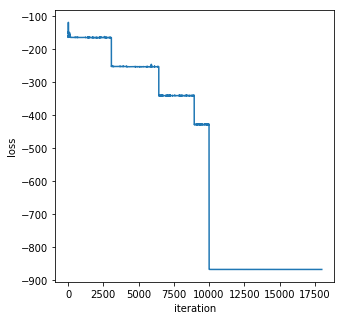

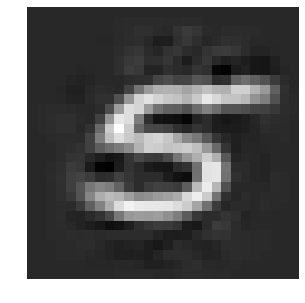

[[-1.677039    0.8850769   1.6695983  -0.39127064 -0.3811868   0.62645197
  -0.1934032   1.0027078 ]]
hessian postive definite
progress in % 60.0
lrate 0.1
iter 0 loss -134.25989 inverse T 0.2
iter 1000 loss -168.648 inverse T 0.2
iter 2000 loss -168.64473 inverse T 0.2
iter 3000 loss -168.63464 inverse T 0.2
iter 4000 loss -256.27 inverse T 0.3
iter 5000 loss -256.269 inverse T 0.3
iter 6000 loss -256.19537 inverse T 0.3
iter 7000 loss -345.92514 inverse T 0.4
iter 8000 loss -345.91415 inverse T 0.4
iter 9000 loss -431.56625 inverse T 0.5
lrate 0.01
iter 0 loss -887.5054 inverse T 1.0
iter 1000 loss -887.62103 inverse T 1.0
iter 2000 loss -887.62494 inverse T 1.0
iter 3000 loss -887.62396 inverse T 1.0
iter 4000 loss -887.6247 inverse T 1.0
lrate 0.001
iter 0 loss -887.62305 inverse T 1.0
iter 1000 loss -887.6259 inverse T 1.0
iter 2000 loss -887.6251 inverse T 1.0


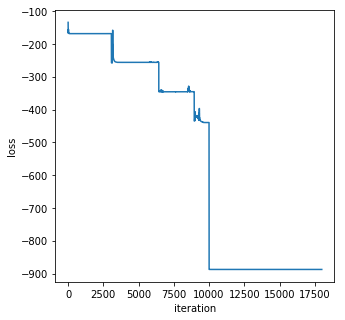

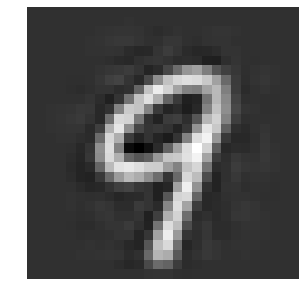

[[ 0.3746518   0.5320726   0.707884   -0.25464493 -0.37659448 -0.8777873
   0.2962291  -0.05060389]]
progress in % 70.0
lrate 0.1
iter 0 loss -126.17205 inverse T 0.2
iter 1000 loss -168.77748 inverse T 0.2
iter 2000 loss -168.76918 inverse T 0.2
iter 3000 loss -168.77481 inverse T 0.2
iter 4000 loss -260.22592 inverse T 0.3
iter 5000 loss -256.515 inverse T 0.3
iter 6000 loss -256.50482 inverse T 0.3
iter 7000 loss -346.04514 inverse T 0.4
iter 8000 loss -346.0853 inverse T 0.4
iter 9000 loss -434.8585 inverse T 0.5
lrate 0.01
iter 0 loss -794.21985 inverse T 1.0
iter 1000 loss -795.1907 inverse T 1.0
iter 2000 loss -795.1853 inverse T 1.0
iter 3000 loss -795.1765 inverse T 1.0
iter 4000 loss -795.1767 inverse T 1.0
lrate 0.001
iter 0 loss -795.1813 inverse T 1.0
iter 1000 loss -795.19464 inverse T 1.0
iter 2000 loss -795.1946 inverse T 1.0


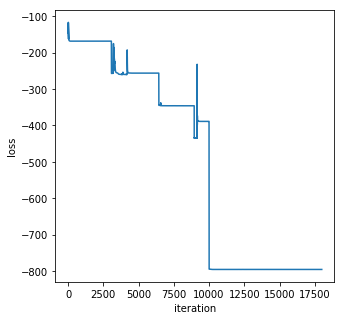

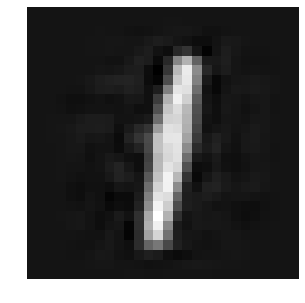

[[-1.5687985  -0.47656822 -1.1818696   0.4682985   0.98341507 -2.2643495
   3.0413208  -0.24932188]]
hessian postive definite
progress in % 80.0
lrate 0.1
iter 0 loss -136.35007 inverse T 0.2
iter 1000 loss -155.3237 inverse T 0.2
iter 2000 loss -155.2981 inverse T 0.2
iter 3000 loss -154.96266 inverse T 0.2
iter 4000 loss -241.26944 inverse T 0.3
iter 5000 loss -241.09038 inverse T 0.3
iter 6000 loss -240.99341 inverse T 0.3
iter 7000 loss -346.0656 inverse T 0.4
iter 8000 loss -347.71002 inverse T 0.4
iter 9000 loss -437.0557 inverse T 0.5
lrate 0.01
iter 0 loss -883.34753 inverse T 1.0
iter 1000 loss -883.4651 inverse T 1.0
iter 2000 loss -883.4632 inverse T 1.0
iter 3000 loss -883.46497 inverse T 1.0
iter 4000 loss -883.463 inverse T 1.0
lrate 0.001
iter 0 loss -883.46466 inverse T 1.0
iter 1000 loss -883.4651 inverse T 1.0
iter 2000 loss -883.4647 inverse T 1.0


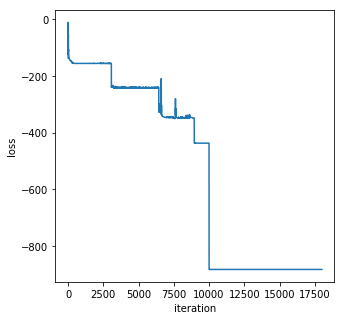

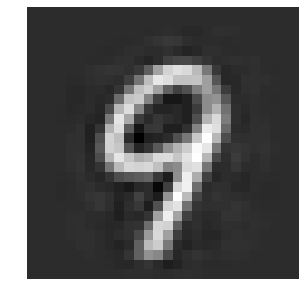

[[ 0.6245799  -0.26703477 -0.9427549  -1.0751722   0.0702629  -0.94230264
   0.17599441  0.675713  ]]
hessian postive definite
progress in % 90.0
lrate 0.1
iter 0 loss -141.76202 inverse T 0.2
iter 1000 loss -166.22672 inverse T 0.2
iter 2000 loss -165.9974 inverse T 0.2
iter 3000 loss -168.45308 inverse T 0.2
iter 4000 loss -257.38232 inverse T 0.3
iter 5000 loss -257.38 inverse T 0.3
iter 6000 loss -257.43643 inverse T 0.3
iter 7000 loss -346.2631 inverse T 0.4
iter 8000 loss -346.26663 inverse T 0.4
iter 9000 loss -429.76923 inverse T 0.5
lrate 0.01
iter 0 loss -871.161 inverse T 1.0
iter 1000 loss -871.4214 inverse T 1.0
iter 2000 loss -873.7579 inverse T 1.0
iter 3000 loss -875.7939 inverse T 1.0
iter 4000 loss -875.8548 inverse T 1.0
lrate 0.001
iter 0 loss -875.85297 inverse T 1.0
iter 1000 loss -875.8655 inverse T 1.0
iter 2000 loss -875.8653 inverse T 1.0


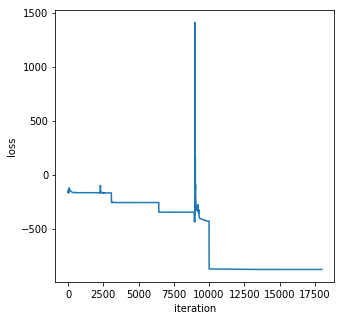

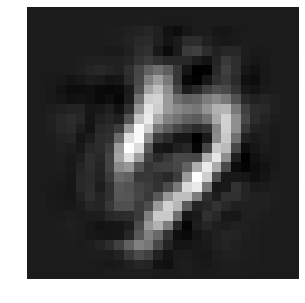

[[-0.18173763 -0.8193924  -0.9272661  -1.7339302  -0.27453798  0.42536798
   2.8876195   0.2009342 ]]
hessian postive definite


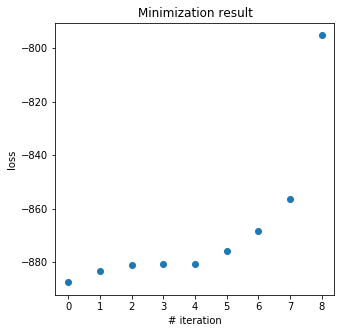

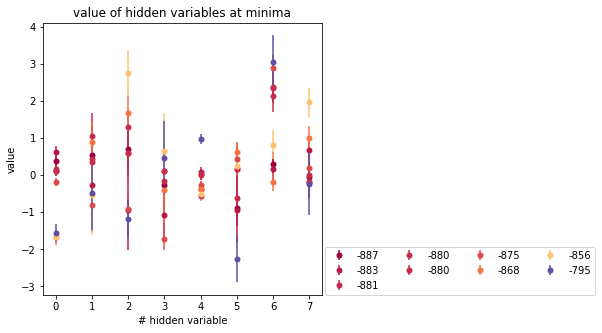

total chi2 of lowest minimum 1719.0 on 784.0 pixels
chi2 of lowest minimum, low pixel amplitude regions 2.2 on 363.0 pixels
chi2 of lowest minimum, high pixel amplitude regions 1716.8 on 421.0 pixels


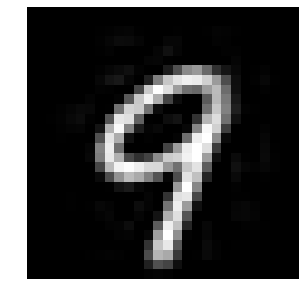

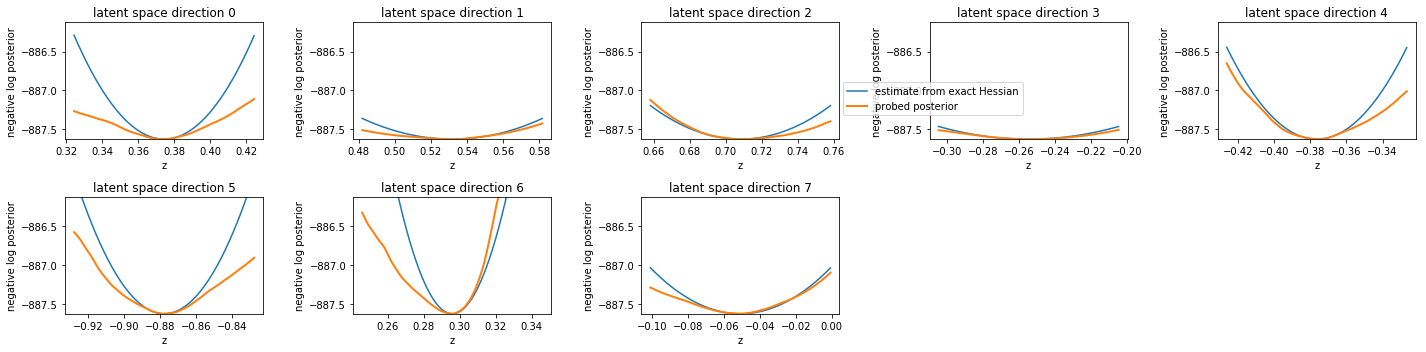

3 3
weights of Gaussian mixtures: [[0.930623  ]
 [0.05492784]
 [0.0144491 ]]


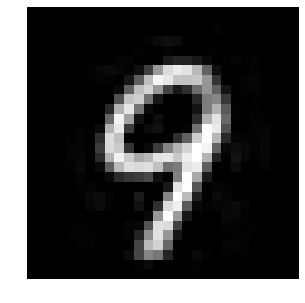

plotting samples drawn from Gaussian Mixture Model


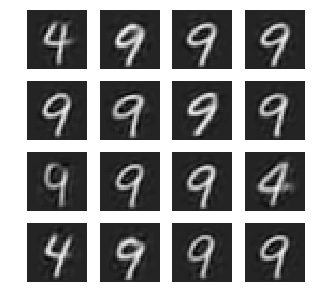

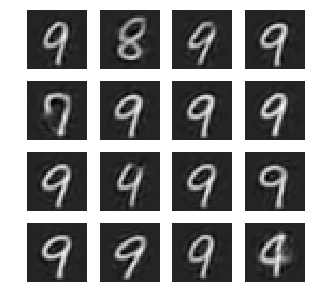

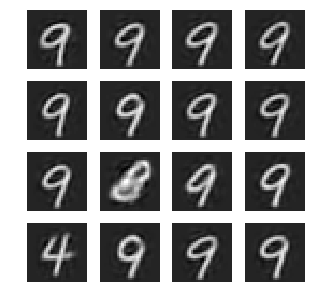

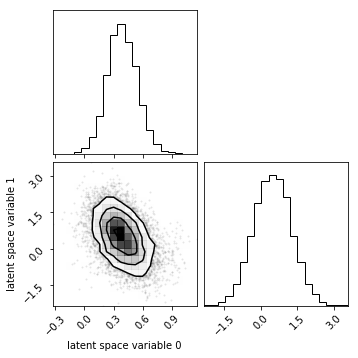

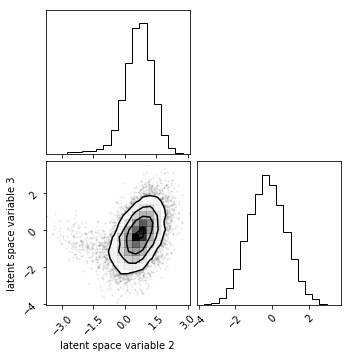

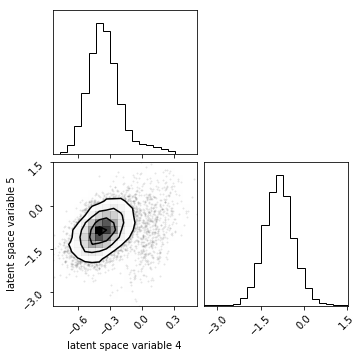

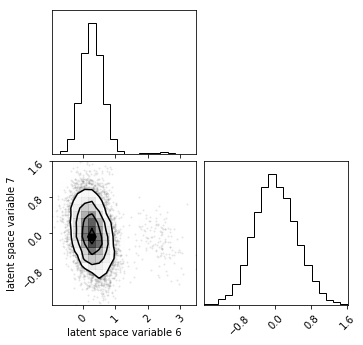

In [0]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  
  
  
  truth = np.expand_dims(x_test[num_mnist:num_mnist+data_size],-1)
  plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
  
  
  data = sess.run(conv_gen,feed_dict={input_data: truth})
  data = data.reshape([data_size,data_dim, n_channels])

  plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')
  
  
  _, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)
  plot_image(noise, directory=plot_path, filename='noise_%s'%label, title='noise')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(10, sess)
  
  try:
    assert(False)
    minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      print(min_z)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    
    pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_%s.pkl'%label,'wb'))

  plot_minima(minima, min_loss, min_var)

  
  chi2s = get_chi2(noise,data,recons[0],masking=True, mask=custom_mask)
  
  
  print('total chi2 of lowest minimum', '%.1f'%chi2s[0], 'on', '%.1f'%chi2s[1] ,'pixels')
  try:
    print('chi2 of lowest minimum, low pixel amplitude regions', '%.1f'%chi2s[2], 'on', '%.1f'%chi2s[3], 'pixels')
    print('chi2 of lowest minimum, high pixel amplitude regions', '%.1f'%chi2s[4], 'on', '%.1f'%chi2s[5], 'pixels')
  except:
    pass
  
  lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
  rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  
  probe_posterior(minima[0], data, noise, custom_mask, sess)
  
  mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[1],minima[3]], data, noise, custom_mask, min_loss[0])
  _ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })
  
  lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[1]})
  rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  
  
  print('plotting samples drawn from Gaussian Mixture Model')
  samples = get_gmm_sample(16,data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s_1'%label)
  
  samples = get_gmm_sample(16,data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s_2'%label)
  
  samples = get_gmm_sample(16,data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s_3'%label)
  
  more_samples = []
  for ii in range(10000):
    more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
  more_samples=np.asarray(more_samples)
  
  for indices in [[0,1],[2,3],[4,5],[6,7]]:
    plot_prob_2D_GMM(more_samples, indices)
  